<a href="https://colab.research.google.com/github/MNoichl/SFI_homework_going_for_lunch/blob/main/choosing_a_restaurant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install git+https://github.com/MNoichl/mesa
!pip install compress-pickle --quiet
!pip install cmocean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import networkx as nx
import random
from scipy.stats import beta
import scipy.stats

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from compress_pickle import dump, load

import cmocean

In [ ]:
%%capture
!pip install git+https://github.com/MNoichl/opinionated.git#egg=opinionated --force-reinstall
import opinionated
plt.style.use("opinionated_rc")

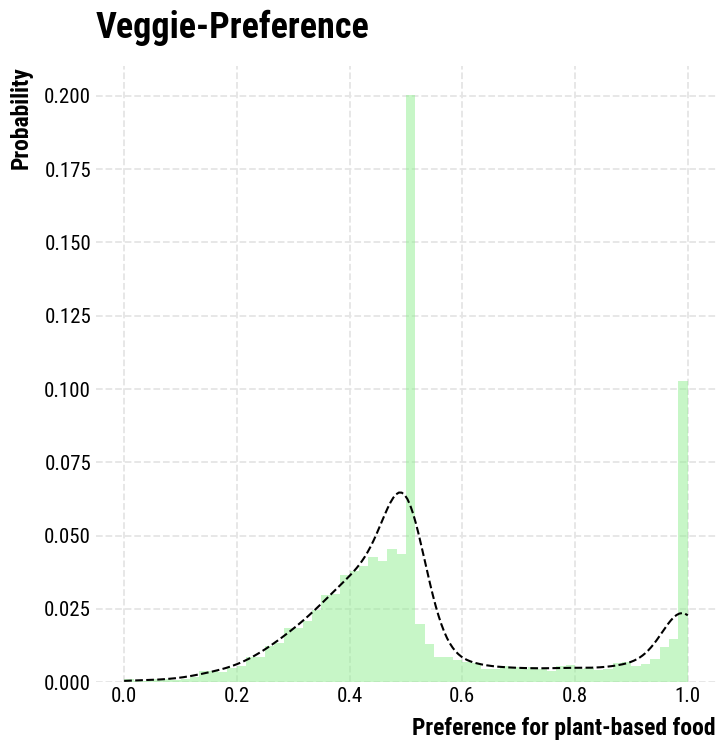

In [ ]:
def return_vegan_preference():
  if random.random() < .5:
    # return min([0, -1 *np.abs(scipy.stats.t.rvs(2, 0, .2)])
    X = np.abs(np.random.normal(loc=0, scale=.3))
    return np.max([0,-0.5 * X + 0.5])
  else:
    return .5 +  beta.rvs(0.13, 0.20) /2

plt.figure(figsize=(8,8))

plot = sns.histplot([return_vegan_preference() for x in range(10000)], kde=True,
             color='lightgreen', alpha=.5, edgecolor=None,
             line_kws = {'linestyle': 'dashed'}, stat="probability")
plt.setp(plot.get_lines(), color='black')
plt.title('Veggie-Preference')

plt.ylabel('Probability')
plt.xlabel('Preference for plant-based food')

plt.savefig('drive/MyDrive/SFI_homework/veg_preference.png' ,bbox_inches='tight',
        dpi =400, transparent=False)


plt.show()

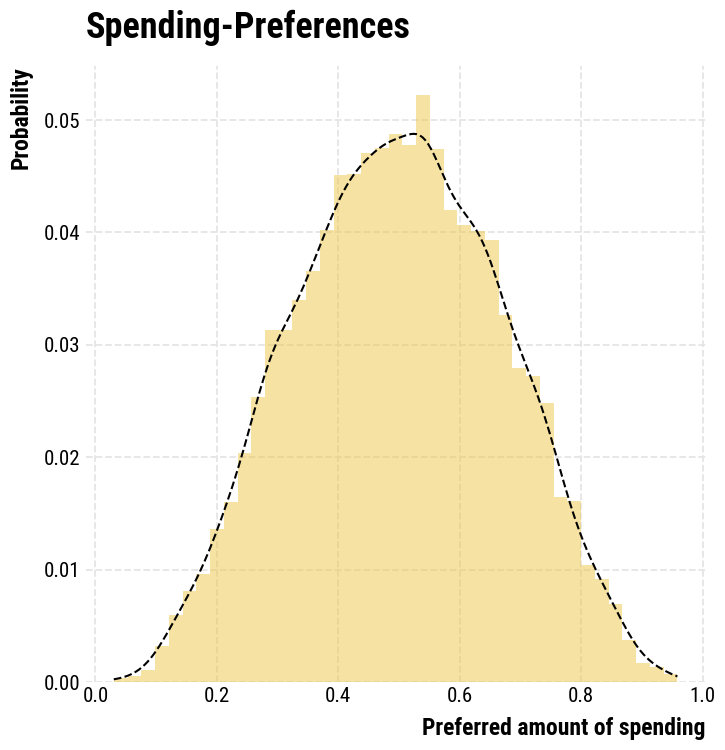

In [ ]:


plt.figure(figsize=(8,8))

plot = sns.histplot([beta.rvs(4, 4) for x in range(10000)], kde=True,
             color='#eec849', alpha=.5, edgecolor=None,
             line_kws = {'linestyle': 'dashed'}, stat="probability")
plt.setp(plot.get_lines(), color='black')
plt.title('Spending-Preferences')

plt.ylabel('Probability')
plt.xlabel('Preferred amount of spending')

plt.savefig('drive/MyDrive/SFI_homework/spending_preference.png' ,bbox_inches='tight',
        dpi =400, transparent=False)


plt.show()

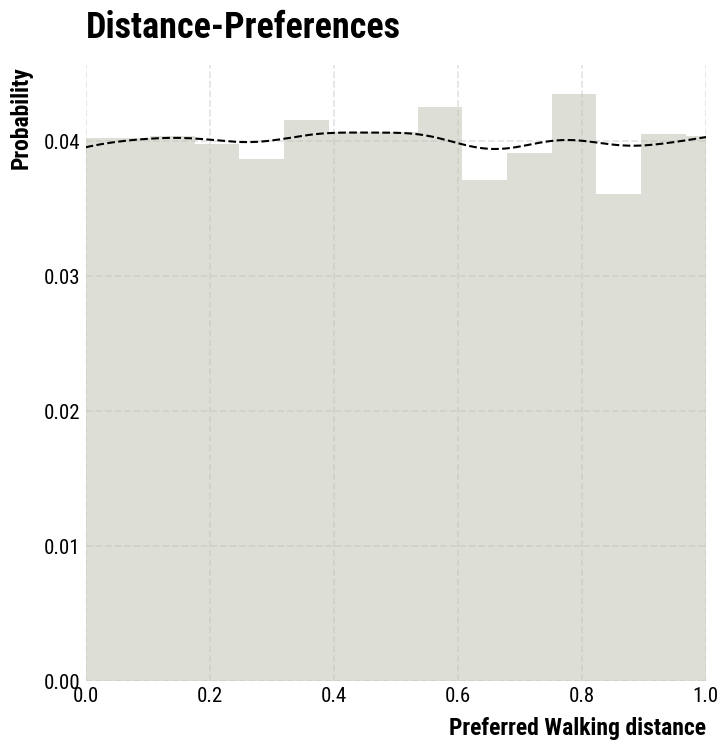

In [ ]:

plt.figure(figsize=(8,8))

plot = sns.histplot([np.random.uniform(-.4,1.4) for x in range(15000)], kde=True,
             color='#bdc1ae', alpha=.5, edgecolor=None,
             line_kws = {'linestyle': 'dashed'}, stat="probability")
plt.setp(plot.get_lines(), color='black')
plt.title('Distance-Preferences')
plt.xlim((0,1))
plt.ylabel('Probability')
plt.xlabel('Preferred Walking distance')
plt.savefig('drive/MyDrive/SFI_homework/walking_dist_preference.png' ,bbox_inches='tight',
        dpi =400, transparent=False)


plt.show()

In [ ]:


def create_preferences():
    preferences = {'vegan': return_vegan_preference(),
                   'price':  beta.rvs(4, 4),
                   'distance': random.random(),
                   }
    return preferences



def return_last_i_want_to_lead(agent):
  return agent.i_want_to_lead_history[-1]

def return_conscientousness(agent):
  return agent.conscientousness


def ensure_neighbors(graph):
  """
  Ensure that all nodes in a NetworkX graph have at least one neighbor.

  Parameters:
  graph (networkx.Graph): The NetworkX graph to check.

  Returns:
  networkx.Graph: The updated NetworkX graph where all nodes have at least one neighbor.
  """
  nodes = list(graph.nodes())
  for node in nodes:
      if len(list(graph.neighbors(node))) == 0:
          # The node has no neighbors, so select another node to connect it with
          other_node = random.choice(nodes)
          while other_node == node:  # Make sure we don't connect the node to itself
              other_node = random.choice(nodes)
          graph.add_edge(node, other_node)
  return graph



class MyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.a = 1
        self.b = 1
        self.preferences = create_preferences()
        self.learned_preferences = {k: [] for k in self.preferences.keys()}  # Initialize with empty lists
        self.conscientousness = random.random() # uniform ?
        self.i_want_to_lead_history = []


    def step(self):
        # Select a random preference
        chosen_preference = random.choice(list(self.preferences.keys()))

        # Select a random neighbour
        neighbours = list(self.model.network.neighbors(self.unique_id))
        if neighbours:  # Proceed only if there are neighbors
            chosen_neighbour = random.choice(neighbours)

            # Find the agent in the schedule
            neighbour_agent = next(agent for agent in self.model.schedule.agents if agent.unique_id == chosen_neighbour)

            # Learn preferences of the chosen neighbour
            self.learned_preferences[chosen_preference].append(neighbour_agent.preferences[chosen_preference])


            # Calculate the difference in preferences
            preference_diff = abs(self.preferences[chosen_preference] - neighbour_agent.preferences[chosen_preference])
            conscientiousness_of_neighbor = neighbour_agent.conscientousness
            self.update_lead_status(preference_diff,conscientiousness_of_neighbor)

    def update_lead_status(self,preference_diff, conscientiousness_of_neighbor): # alpha makes go up, beta makes go down.

      if (preference_diff > 0.5) and (conscientiousness_of_neighbor > 0.5):
        self.b += 1
      elif (preference_diff < 0.5) and (conscientiousness_of_neighbor > 0.5):
        self.b += 1
      elif (preference_diff > 0.5) and (conscientiousness_of_neighbor < 0.5):
        self.a += 1
      elif (preference_diff < 0.5) and (conscientiousness_of_neighbor < 0.5):
        self.b += 1
      self.i_want_to_lead_history.append(beta.stats(self.a,self.b, moments='m')) # change away from mean?





class MyModel(Model):
    def __init__(self, network_type):
        if network_type == 'fully_connected':
          self.network = nx.complete_graph(10)
        elif network_type == 'random_geometric':
          self.rgg_radius = np.random.uniform(low=0.05, high=1.0)
          self.network = ensure_neighbors(nx.random_geometric_graph(10, radius=self.rgg_radius))
        # self.network_svg_shortest_path_length = nx.average_shortest_path_length(self.network)
        self.average_clustering = nx.average_clustering(self.network)
        self.num_agents = len(self.network.nodes())
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MyAgent(i, self)
            self.schedule.add(a)

        self.datacollector = DataCollector(agent_reporters={"conscientiousness": return_conscientousness, "i_want_to_lead": return_last_i_want_to_lead},
                                            model_reporters={"decision_success": self.compute_weighted_preferences,
                                                             "difference_to_leader":self.compute_difference_to_leader,
                                                            #  "network_svg_shortest_path_length": self.return_avg_short_path
                                                             "average_clustering": self.return_average_clustering,
                                                              "rgg_radius": self.return_rgg_radius,
                                                            #  'difference_to_random_leader'
                                                             'decision_success_with_random_leader': self.compute_weighted_preferences_with_random_leader,

                                                             })
    def return_rgg_radius(self):
      return self.rgg_radius


    def return_average_clustering(self):
      return self.average_clustering

    # def return_avg_short_path(self):
    #   return self.network_svg_shortest_path_length

    def compute_weighted_preferences(self):
      # Get the agent with the highest i_want_to_lead value at the last step
      best_agent = max(self.schedule.agents, key=lambda a: a.i_want_to_lead_history[-1])

      # Calculate the median values for each learned preference
      medians_learned = {preference: np.nanmedian(values) for preference, values in best_agent.learned_preferences.items() if values}

      # Calculate the weighted average of own preferences and learned preferences, weighted by conscientiousness
      weighted_preferences = {preference: best_agent.conscientousness * medians_learned.get(preference, 0)
                              + (1 - best_agent.conscientousness) * best_agent.preferences[preference]
                              for preference in best_agent.preferences.keys()}

      # Calculate the mean of the mean differences between the weighted_preferences and each individual agent's preferences
      mean_diffs = []
      for agent in model.schedule.agents:
          diffs = [abs(weighted_preferences[preference] - agent.preferences[preference]) for preference in weighted_preferences.keys()]
          mean_diffs.append(sum(diffs) / len(diffs))

      mean_of_means = sum(mean_diffs) / len(mean_diffs)

      return mean_of_means

    def compute_weighted_preferences_with_random_leader(self):
        # Get a random agent
        best_agent = random.choice(self.schedule.agents)

        # Calculate the median values for each learned preference
        medians_learned = {preference: np.nanmedian(values) for preference, values in best_agent.learned_preferences.items() if values}

        # Calculate the weighted average of own preferences and learned preferences, weighted by conscientiousness
        weighted_preferences = {preference: best_agent.conscientousness * medians_learned.get(preference, 0)
                                + (1 - best_agent.conscientousness) * best_agent.preferences[preference]
                                for preference in best_agent.preferences.keys()}

        # Calculate the mean of the mean differences between the weighted_preferences and each individual agent's preferences
        mean_diffs = []
        for agent in model.schedule.agents:
            diffs = [abs(weighted_preferences[preference] - agent.preferences[preference]) for preference in weighted_preferences.keys()]
            mean_diffs.append(sum(diffs) / len(diffs))

        mean_of_means = sum(mean_diffs) / len(mean_diffs)

        return mean_of_means



    def compute_difference_to_leader(self):
      # Get the agent with the highest i_want_to_lead value at the last step
      best_agent = max(self.schedule.agents, key=lambda a: a.i_want_to_lead_history[-1])

      # Calculate the mean of the mean differences between the weighted_preferences and each individual agent's preferences
      mean_diffs = []
      for agent in model.schedule.agents:
          diffs = [abs(best_agent.preferences[preference] - agent.preferences[preference]) for preference in best_agent.preferences.keys()]
          mean_diffs.append(sum(diffs) / len(diffs))

      mean_of_means = sum(mean_diffs) / len(mean_diffs)

      return mean_of_means




    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()
        self.datacollector.collect(self)



# Create model
model = MyModel('random_geometric')

# Run model
for i in range(100):
    model.step()


In [ ]:
# Chekc the difference between leader-preferences and mean preferences
# add rgg?

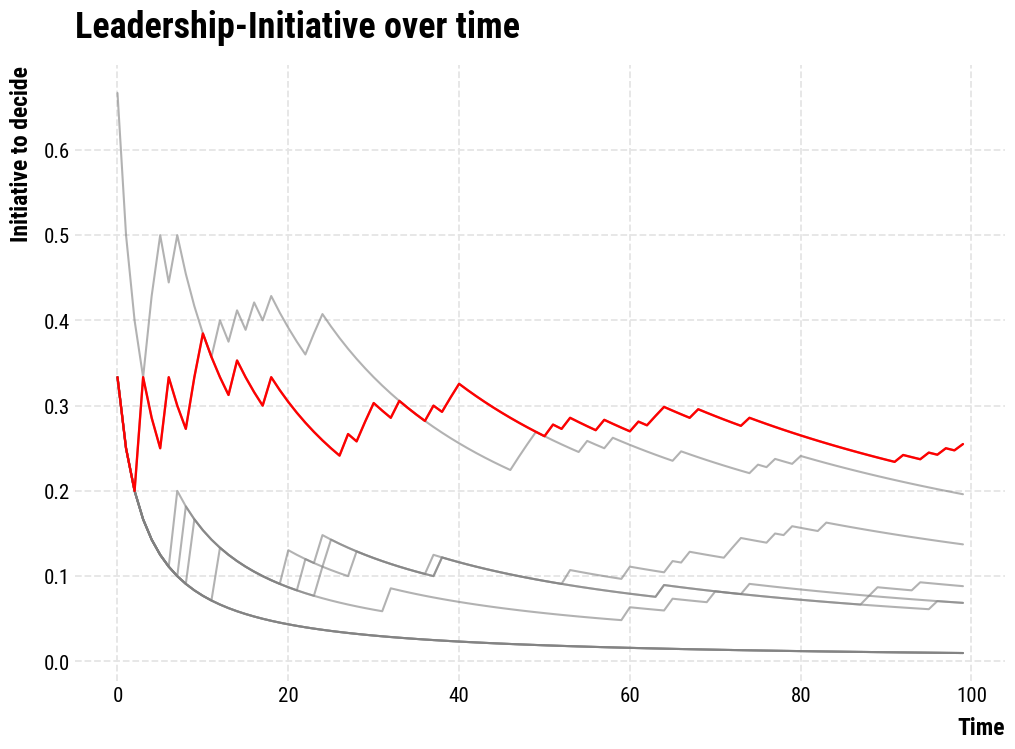

In [ ]:



plt.figure(figsize=(12,8))
max_initiative = 0
for agent in model.schedule.agents:
    plt.plot(agent.i_want_to_lead_history, label=f'Agent {agent.unique_id}',alpha=.6, color='grey')
    if agent.i_want_to_lead_history[-1] > max_initiative:
      best_agent = agent
      max_initiative = agent.i_want_to_lead_history[-1]

plt.plot(best_agent.i_want_to_lead_history, label=f'Agent {agent.unique_id}',alpha=1, color='red',linewidth=1.7)

plt.xlabel('Time')
plt.ylabel('Initiative to decide')
# plt.legend()
plt.title('Leadership-Initiative over time')

plt.savefig('drive/MyDrive/SFI_homework/leader_emergence_example.png' ,bbox_inches='tight',
        dpi =400, transparent=False)

plt.show()

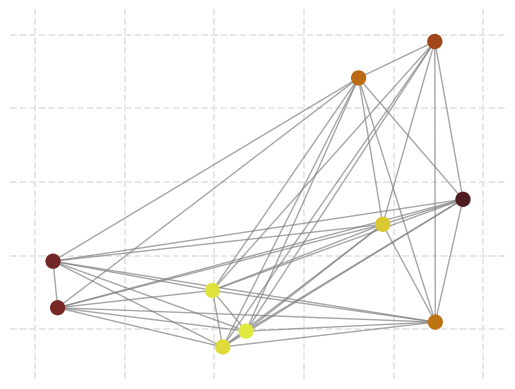

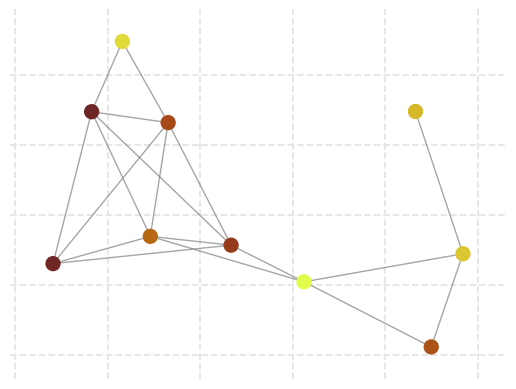

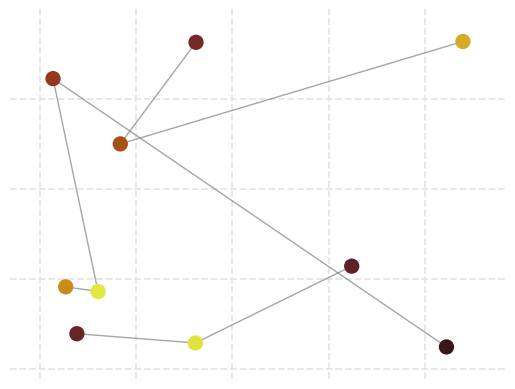

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Define the number of nodes
n_nodes = 10  # Replace this with the number of nodes you want

# Define the radius for the geometric graph
rgg_radius = 1. # Replace this with the radius you want

# Define the graph
G = nx.random_geometric_graph(n_nodes, rgg_radius)

G = ensure_neighbors(G)

# Get the positions
positions = nx.get_node_attributes(G, "pos")

# Create the positions dictionary
pos_dict = {i: positions[i] for i in range(len(positions))}

# Plotting
node_colors = [ cmocean.cm.solar(np.random.uniform()) for _ in range(len(G.nodes))]
nx.draw_networkx_edges(G, pos_dict, edge_color="grey", width=1, alpha=.7)
nx.draw_networkx_nodes(G, pos_dict, node_size=100,  node_color=node_colors, alpha=1.)
plt.savefig('drive/MyDrive/SFI_homework/graph_high_connect.png' ,bbox_inches='tight',
        dpi =400, transparent=False)

plt.show()



# Define the radius for the geometric graph
rgg_radius = .5 # Replace this with the radius you want

# Define the graph
G = nx.random_geometric_graph(n_nodes, rgg_radius)

G = ensure_neighbors(G)

# Get the positions
positions = nx.get_node_attributes(G, "pos")

# Create the positions dictionary
pos_dict = {i: positions[i] for i in range(len(positions))}

# Plotting
node_colors = [ cmocean.cm.solar(np.random.uniform()) for _ in range(len(G.nodes))]
nx.draw_networkx_edges(G, pos_dict, edge_color="grey", width=1, alpha=.7)
nx.draw_networkx_nodes(G, pos_dict, node_size=100,  node_color=node_colors, alpha=1.)
plt.savefig('drive/MyDrive/SFI_homework/graph_medium_connect.png' ,bbox_inches='tight',
        dpi =400, transparent=False)

plt.show()



# Define the radius for the geometric graph
rgg_radius = .1 # Replace this with the radius you want

# Define the graph
G = nx.random_geometric_graph(n_nodes, rgg_radius)

G = ensure_neighbors(G)

# Get the positions
positions = nx.get_node_attributes(G, "pos")

# Create the positions dictionary
pos_dict = {i: positions[i] for i in range(len(positions))}

# Plotting
node_colors = [ cmocean.cm.solar(np.random.uniform()) for _ in range(len(G.nodes))]
nx.draw_networkx_edges(G, pos_dict, edge_color="grey", width=1, alpha=.7)
nx.draw_networkx_nodes(G, pos_dict, node_size=100,  node_color=node_colors, alpha=1.)
plt.savefig('drive/MyDrive/SFI_homework/graph_low_connect.png' ,bbox_inches='tight',
        dpi =400, transparent=False)

plt.show()

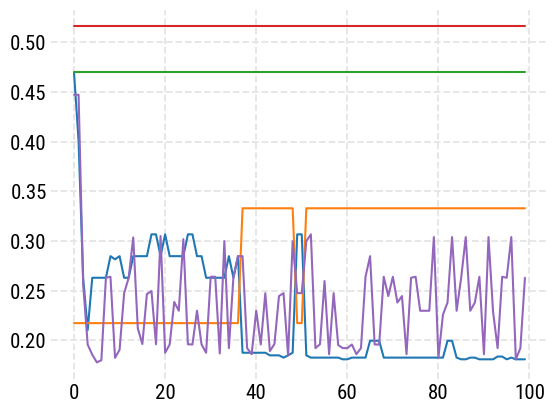

In [ ]:
plt.plot(model.datacollector.get_model_vars_dataframe())

In [ ]:
agent_df = model.datacollector.get_agent_vars_dataframe().reset_index()
agent_df

,Step,AgentID,conscientiousness,i_want_to_lead
0,1,0,0.928340,0.666667
1,1,1,0.713744,0.333333
2,1,2,0.060444,0.333333
3,1,3,0.314945,0.333333
4,1,4,0.239033,0.333333
...,...,...,...,...
995,100,5,0.892140,0.254902
996,100,6,0.869539,0.009804
997,100,7,0.386258,0.068627
998,100,8,0.096891,0.068627


In [ ]:
# Import necessary packages
from mesa.batchrunner import batch_run

def create_params(k, base_params):
    """
    This function creates a list of dictionaries based on a base dictionary. It modifies the values of the base
    dictionary depending on their type:
    - If the value is a tuple, it generates a random number within the range defined by the tuple.
      If any number in the tuple is a float, it treats the entire range as a float range.
    - If the value is a list, it selects a random element from the list.
    - If the value is a dictionary, it expects that it contains a function and its arguments,
      and it calls the function with these arguments.
    The function returns a list of 'k' such dictionaries.

    Args:
        k (int): Number of dictionaries to create.
        base_params (dict): The base dictionary.

    Returns:
        list: A list of dictionaries.
    """
    param_list = []
    for _ in tqdm.tqdm_notebook(range(k)):
        params = base_params.copy()  # make a copy of the base parameters
        for key, value in params.items():
            if isinstance(value, tuple):  # if the value is a tuple, generate a random number
                if any(isinstance(i, float) for i in value):  # if any number in the tuple is a float, generate a float
                    params[key] = random.uniform(value[0], value[1])
                else:
                    params[key] = random.randint(value[0], value[1])  # random integer between the two numbers
            elif isinstance(value, list):  # if the value is a list, select a random element
                params[key] = random.choice(value)
            elif isinstance(value, dict):  # if the value is a dictionary, call the function with its arguments
                function = value["function"]
                args = value.get("args", [])
                kwargs = value.get("kwargs", {})
                params[key] = function(*args, **kwargs)
        param_list.append(params)
    return param_list





base_params = {
    'network_type': ['random_geometric']
}


param_list = create_params(100000, base_params)  # This will create a list of 10 dictionaries.


<ipython-input-20-75ccd942d9e8>:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm.tqdm_notebook(range(k)):


  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
import os
import pickle

def batch_run_with_chunks(parameters, model_cls, iterations=1, max_steps=500, number_processes=None, display_progress=True, directory="chunks"):
    # Make sure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Cut the parameter list into chunks of 200
    chunks = [parameters[i:i + 200] for i in range(0, len(parameters), 200)]
    max_run_id = 0
    for i, chunk in enumerate(chunks):
        print(f"Running chunk {i+1} out of {len(chunks)}")
        # Initialize and run the BatchRunner
        run_data = batch_run(
            model_cls = model_cls,
            parameters= chunk,
            iterations=iterations,  # You can change the number of iterations
            max_steps=max_steps,  # You can change the number of max steps
            number_processes=number_processes, # use all available cores!
            display_progress=display_progress,
        )

        run_data_df = pd.DataFrame(run_data)
        run_data_df['RunId'] = [x + max_run_id for x in run_data_df['RunId']]
        max_run_id = np.max(run_data_df['RunId'])
        dump(run_data_df,os.path.join(directory, f'chunk_{i+1}.bz'))

batch_run_with_chunks(param_list, MyModel, iterations=1,
                      max_steps=100, number_processes=None,
                      display_progress=True,
                      directory="drive/MyDrive/SFI_homework/random_geometric_with_random_leader_10000")



# run_data now holds a pandas DataFrame that contains the Mean, Median, and STD data
# collected for each run, along with the values of the parameters for that run


Running chunk 1 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.13it/s]


Running chunk 2 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Running chunk 3 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


Running chunk 4 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.42it/s]


Running chunk 5 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.70it/s]


Running chunk 6 out of 500


100%|██████████| 200/200 [00:09<00:00, 20.94it/s]


Running chunk 7 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.36it/s]


Running chunk 8 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.38it/s]


Running chunk 9 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.06it/s]


Running chunk 10 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.55it/s]


Running chunk 11 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.59it/s]


Running chunk 12 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.69it/s]


Running chunk 13 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.17it/s]


Running chunk 14 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.14it/s]


Running chunk 15 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.17it/s]


Running chunk 16 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.52it/s]


Running chunk 17 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.19it/s]


Running chunk 18 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.90it/s]


Running chunk 19 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.58it/s]


Running chunk 20 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.86it/s]


Running chunk 21 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.96it/s]


Running chunk 22 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.59it/s]


Running chunk 23 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.22it/s]


Running chunk 24 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.39it/s]


Running chunk 25 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


Running chunk 26 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.73it/s]


Running chunk 27 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.35it/s]


Running chunk 28 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.42it/s]


Running chunk 29 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.98it/s]


Running chunk 30 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.14it/s]


Running chunk 31 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.77it/s]


Running chunk 32 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.44it/s]


Running chunk 33 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.82it/s]


Running chunk 34 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.33it/s]


Running chunk 35 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.93it/s]


Running chunk 36 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.23it/s]


Running chunk 37 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.19it/s]


Running chunk 38 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.60it/s]


Running chunk 39 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.23it/s]


Running chunk 40 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.35it/s]


Running chunk 41 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.11it/s]


Running chunk 42 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.53it/s]


Running chunk 43 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.55it/s]


Running chunk 44 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.28it/s]


Running chunk 45 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.82it/s]


Running chunk 46 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.09it/s]


Running chunk 47 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.04it/s]


Running chunk 48 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.00it/s]


Running chunk 49 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.00it/s]


Running chunk 50 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.93it/s]


Running chunk 51 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.18it/s]


Running chunk 52 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.72it/s]


Running chunk 53 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Running chunk 54 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.70it/s]


Running chunk 55 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.46it/s]


Running chunk 56 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.11it/s]


Running chunk 57 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.63it/s]


Running chunk 58 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.65it/s]


Running chunk 59 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.30it/s]


Running chunk 60 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.68it/s]


Running chunk 61 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.02it/s]


Running chunk 62 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.48it/s]


Running chunk 63 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.41it/s]


Running chunk 64 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Running chunk 65 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.30it/s]


Running chunk 66 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.70it/s]


Running chunk 67 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.32it/s]


Running chunk 68 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.47it/s]


Running chunk 69 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.11it/s]


Running chunk 70 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.09it/s]


Running chunk 71 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.48it/s]


Running chunk 72 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.00it/s]


Running chunk 73 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.89it/s]


Running chunk 74 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.51it/s]


Running chunk 75 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.75it/s]


Running chunk 76 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.48it/s]


Running chunk 77 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.49it/s]


Running chunk 78 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.15it/s]


Running chunk 79 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.32it/s]


Running chunk 80 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


Running chunk 81 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.77it/s]


Running chunk 82 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.15it/s]


Running chunk 83 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.40it/s]


Running chunk 84 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.68it/s]


Running chunk 85 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.03it/s]


Running chunk 86 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.19it/s]


Running chunk 87 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.93it/s]


Running chunk 88 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.15it/s]


Running chunk 89 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.99it/s]


Running chunk 90 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 91 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.24it/s]


Running chunk 92 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.26it/s]


Running chunk 93 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.92it/s]


Running chunk 94 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.53it/s]


Running chunk 95 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.03it/s]


Running chunk 96 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.78it/s]


Running chunk 97 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.36it/s]


Running chunk 98 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.54it/s]


Running chunk 99 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.09it/s]


Running chunk 100 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.35it/s]


Running chunk 101 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.86it/s]


Running chunk 102 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.56it/s]


Running chunk 103 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.90it/s]


Running chunk 104 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.97it/s]


Running chunk 105 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.71it/s]


Running chunk 106 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.93it/s]


Running chunk 107 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.99it/s]


Running chunk 108 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.65it/s]


Running chunk 109 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.45it/s]


Running chunk 110 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.53it/s]


Running chunk 111 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Running chunk 112 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.58it/s]


Running chunk 113 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.66it/s]


Running chunk 114 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.15it/s]


Running chunk 115 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.76it/s]


Running chunk 116 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.74it/s]


Running chunk 117 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 118 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.81it/s]


Running chunk 119 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.45it/s]


Running chunk 120 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.61it/s]


Running chunk 121 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.03it/s]


Running chunk 122 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.85it/s]


Running chunk 123 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.73it/s]


Running chunk 124 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.21it/s]


Running chunk 125 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.69it/s]


Running chunk 126 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.48it/s]


Running chunk 127 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.72it/s]


Running chunk 128 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.57it/s]


Running chunk 129 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.01it/s]


Running chunk 130 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.61it/s]


Running chunk 131 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Running chunk 132 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.93it/s]


Running chunk 133 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Running chunk 134 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.66it/s]


Running chunk 135 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.58it/s]


Running chunk 136 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Running chunk 137 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.67it/s]


Running chunk 138 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.95it/s]


Running chunk 139 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.22it/s]


Running chunk 140 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.06it/s]


Running chunk 141 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.84it/s]


Running chunk 142 out of 500


100%|██████████| 200/200 [00:07<00:00, 26.14it/s]


Running chunk 143 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.73it/s]


Running chunk 144 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.41it/s]


Running chunk 145 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Running chunk 146 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.58it/s]


Running chunk 147 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.73it/s]


Running chunk 148 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.66it/s]


Running chunk 149 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.70it/s]


Running chunk 150 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.01it/s]


Running chunk 151 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.43it/s]


Running chunk 152 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.73it/s]


Running chunk 153 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.07it/s]


Running chunk 154 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.26it/s]


Running chunk 155 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.97it/s]


Running chunk 156 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.01it/s]


Running chunk 157 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.92it/s]


Running chunk 158 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.83it/s]


Running chunk 159 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.02it/s]


Running chunk 160 out of 500


100%|██████████| 200/200 [00:07<00:00, 26.34it/s]


Running chunk 161 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.86it/s]


Running chunk 162 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.92it/s]


Running chunk 163 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.85it/s]


Running chunk 164 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Running chunk 165 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.28it/s]


Running chunk 166 out of 500


100%|██████████| 200/200 [00:07<00:00, 26.09it/s]


Running chunk 167 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 168 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.80it/s]


Running chunk 169 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.40it/s]


Running chunk 170 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Running chunk 171 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.49it/s]


Running chunk 172 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.96it/s]


Running chunk 173 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.04it/s]


Running chunk 174 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.76it/s]


Running chunk 175 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.69it/s]


Running chunk 176 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.30it/s]


Running chunk 177 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.17it/s]


Running chunk 178 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.49it/s]


Running chunk 179 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.14it/s]


Running chunk 180 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.51it/s]


Running chunk 181 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.00it/s]


Running chunk 182 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.69it/s]


Running chunk 183 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.55it/s]


Running chunk 184 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.24it/s]


Running chunk 185 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.92it/s]


Running chunk 186 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.08it/s]


Running chunk 187 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.00it/s]


Running chunk 188 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.31it/s]


Running chunk 189 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.29it/s]


Running chunk 190 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.23it/s]


Running chunk 191 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.07it/s]


Running chunk 192 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.00it/s]


Running chunk 193 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.69it/s]


Running chunk 194 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.31it/s]


Running chunk 195 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.98it/s]


Running chunk 196 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.10it/s]


Running chunk 197 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.42it/s]


Running chunk 198 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.67it/s]


Running chunk 199 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.96it/s]


Running chunk 200 out of 500


100%|██████████| 200/200 [00:07<00:00, 26.02it/s]


Running chunk 201 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.89it/s]


Running chunk 202 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.86it/s]


Running chunk 203 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.80it/s]


Running chunk 204 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.93it/s]


Running chunk 205 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 206 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.99it/s]


Running chunk 207 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.57it/s]


Running chunk 208 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.08it/s]


Running chunk 209 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.69it/s]


Running chunk 210 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.23it/s]


Running chunk 211 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.91it/s]


Running chunk 212 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.26it/s]


Running chunk 213 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.85it/s]


Running chunk 214 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.92it/s]


Running chunk 215 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.69it/s]


Running chunk 216 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.14it/s]


Running chunk 217 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.46it/s]


Running chunk 218 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.28it/s]


Running chunk 219 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.77it/s]


Running chunk 220 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.05it/s]


Running chunk 221 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.61it/s]


Running chunk 222 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.10it/s]


Running chunk 223 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.33it/s]


Running chunk 224 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.29it/s]


Running chunk 225 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.82it/s]


Running chunk 226 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.10it/s]


Running chunk 227 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.59it/s]


Running chunk 228 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.53it/s]


Running chunk 229 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.10it/s]


Running chunk 230 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.96it/s]


Running chunk 231 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 232 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.08it/s]


Running chunk 233 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.03it/s]


Running chunk 234 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.10it/s]


Running chunk 235 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.29it/s]


Running chunk 236 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.35it/s]


Running chunk 237 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.54it/s]


Running chunk 238 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.84it/s]


Running chunk 239 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


Running chunk 240 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]


Running chunk 241 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.24it/s]


Running chunk 242 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.54it/s]


Running chunk 243 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.50it/s]


Running chunk 244 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.22it/s]


Running chunk 245 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.40it/s]


Running chunk 246 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.58it/s]


Running chunk 247 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.68it/s]


Running chunk 248 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.61it/s]


Running chunk 249 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.18it/s]


Running chunk 250 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


Running chunk 251 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.72it/s]


Running chunk 252 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.65it/s]


Running chunk 253 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.81it/s]


Running chunk 254 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.84it/s]


Running chunk 255 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


Running chunk 256 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.55it/s]


Running chunk 257 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.81it/s]


Running chunk 258 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.79it/s]


Running chunk 259 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.64it/s]


Running chunk 260 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.65it/s]


Running chunk 261 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.66it/s]


Running chunk 262 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.59it/s]


Running chunk 263 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.75it/s]


Running chunk 264 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Running chunk 265 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.83it/s]


Running chunk 266 out of 500


100%|██████████| 200/200 [00:07<00:00, 26.18it/s]


Running chunk 267 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.58it/s]


Running chunk 268 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.23it/s]


Running chunk 269 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.61it/s]


Running chunk 270 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.14it/s]


Running chunk 271 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.68it/s]


Running chunk 272 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.14it/s]


Running chunk 273 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.95it/s]


Running chunk 274 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.24it/s]


Running chunk 275 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.88it/s]


Running chunk 276 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.11it/s]


Running chunk 277 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.35it/s]


Running chunk 278 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.45it/s]


Running chunk 279 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.39it/s]


Running chunk 280 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.70it/s]


Running chunk 281 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


Running chunk 282 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.77it/s]


Running chunk 283 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.59it/s]


Running chunk 284 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.52it/s]


Running chunk 285 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.00it/s]


Running chunk 286 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.52it/s]


Running chunk 287 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.60it/s]


Running chunk 288 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.04it/s]


Running chunk 289 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.60it/s]


Running chunk 290 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.18it/s]


Running chunk 291 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.00it/s]


Running chunk 292 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.88it/s]


Running chunk 293 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.38it/s]


Running chunk 294 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.99it/s]


Running chunk 295 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.06it/s]


Running chunk 296 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.94it/s]


Running chunk 297 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.65it/s]


Running chunk 298 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.66it/s]


Running chunk 299 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.75it/s]


Running chunk 300 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.99it/s]


Running chunk 301 out of 500


100%|██████████| 200/200 [00:09<00:00, 20.80it/s]


Running chunk 302 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.80it/s]


Running chunk 303 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.24it/s]


Running chunk 304 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.71it/s]


Running chunk 305 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.93it/s]


Running chunk 306 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.87it/s]


Running chunk 307 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.46it/s]


Running chunk 308 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.20it/s]


Running chunk 309 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.82it/s]


Running chunk 310 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.83it/s]


Running chunk 311 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.35it/s]


Running chunk 312 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.49it/s]


Running chunk 313 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.18it/s]


Running chunk 314 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.15it/s]


Running chunk 315 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.23it/s]


Running chunk 316 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.52it/s]


Running chunk 317 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


Running chunk 318 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.04it/s]


Running chunk 319 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.38it/s]


Running chunk 320 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.79it/s]


Running chunk 321 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.49it/s]


Running chunk 322 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.76it/s]


Running chunk 323 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.52it/s]


Running chunk 324 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.36it/s]


Running chunk 325 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.40it/s]


Running chunk 326 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.33it/s]


Running chunk 327 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.88it/s]


Running chunk 328 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.04it/s]


Running chunk 329 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.43it/s]


Running chunk 330 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Running chunk 331 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.94it/s]


Running chunk 332 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.02it/s]


Running chunk 333 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.11it/s]


Running chunk 334 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.45it/s]


Running chunk 335 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.12it/s]


Running chunk 336 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.12it/s]


Running chunk 337 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.25it/s]


Running chunk 338 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.15it/s]


Running chunk 339 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Running chunk 340 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.62it/s]


Running chunk 341 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.94it/s]


Running chunk 342 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.02it/s]


Running chunk 343 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.44it/s]


Running chunk 344 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.07it/s]


Running chunk 345 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.77it/s]


Running chunk 346 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.53it/s]


Running chunk 347 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.82it/s]


Running chunk 348 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.48it/s]


Running chunk 349 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.57it/s]


Running chunk 350 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.95it/s]


Running chunk 351 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.84it/s]


Running chunk 352 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Running chunk 353 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.89it/s]


Running chunk 354 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.78it/s]


Running chunk 355 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.42it/s]


Running chunk 356 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.32it/s]


Running chunk 357 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.38it/s]


Running chunk 358 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Running chunk 359 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.52it/s]


Running chunk 360 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.62it/s]


Running chunk 361 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.55it/s]


Running chunk 362 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Running chunk 363 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.29it/s]


Running chunk 364 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.70it/s]


Running chunk 365 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.77it/s]


Running chunk 366 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.05it/s]


Running chunk 367 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.08it/s]


Running chunk 368 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Running chunk 369 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.93it/s]


Running chunk 370 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.49it/s]


Running chunk 371 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.98it/s]


Running chunk 372 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.32it/s]


Running chunk 373 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.04it/s]


Running chunk 374 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.86it/s]


Running chunk 375 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.95it/s]


Running chunk 376 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.61it/s]


Running chunk 377 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.90it/s]


Running chunk 378 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.77it/s]


Running chunk 379 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.67it/s]


Running chunk 380 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.51it/s]


Running chunk 381 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.78it/s]


Running chunk 382 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.92it/s]


Running chunk 383 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.12it/s]


Running chunk 384 out of 500


100%|██████████| 200/200 [00:09<00:00, 22.13it/s]


Running chunk 385 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.50it/s]


Running chunk 386 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.52it/s]


Running chunk 387 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.84it/s]


Running chunk 388 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.44it/s]


Running chunk 389 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.07it/s]


Running chunk 390 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.96it/s]


Running chunk 391 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.85it/s]


Running chunk 392 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.03it/s]


Running chunk 393 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.88it/s]


Running chunk 394 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.38it/s]


Running chunk 395 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.74it/s]


Running chunk 396 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 397 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.77it/s]


Running chunk 398 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.25it/s]


Running chunk 399 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.48it/s]


Running chunk 400 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.50it/s]


Running chunk 401 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.91it/s]


Running chunk 402 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.87it/s]


Running chunk 403 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.34it/s]


Running chunk 404 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.64it/s]


Running chunk 405 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.24it/s]


Running chunk 406 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.25it/s]


Running chunk 407 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.29it/s]


Running chunk 408 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.25it/s]


Running chunk 409 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.61it/s]


Running chunk 410 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.85it/s]


Running chunk 411 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.51it/s]


Running chunk 412 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.29it/s]


Running chunk 413 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Running chunk 414 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.57it/s]


Running chunk 415 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.78it/s]


Running chunk 416 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.82it/s]


Running chunk 417 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.39it/s]


Running chunk 418 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.48it/s]


Running chunk 419 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.98it/s]


Running chunk 420 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.38it/s]


Running chunk 421 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.57it/s]


Running chunk 422 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.38it/s]


Running chunk 423 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.25it/s]


Running chunk 424 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


Running chunk 425 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.36it/s]


Running chunk 426 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.84it/s]


Running chunk 427 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.83it/s]


Running chunk 428 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.88it/s]


Running chunk 429 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.26it/s]


Running chunk 430 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.91it/s]


Running chunk 431 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.46it/s]


Running chunk 432 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.74it/s]


Running chunk 433 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.76it/s]


Running chunk 434 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.77it/s]


Running chunk 435 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.85it/s]


Running chunk 436 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.66it/s]


Running chunk 437 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.46it/s]


Running chunk 438 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.82it/s]


Running chunk 439 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.64it/s]


Running chunk 440 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.15it/s]


Running chunk 441 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.89it/s]


Running chunk 442 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.16it/s]


Running chunk 443 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.60it/s]


Running chunk 444 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.16it/s]


Running chunk 445 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.38it/s]


Running chunk 446 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.35it/s]


Running chunk 447 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.67it/s]


Running chunk 448 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 449 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.92it/s]


Running chunk 450 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.86it/s]


Running chunk 451 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.56it/s]


Running chunk 452 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.65it/s]


Running chunk 453 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.67it/s]


Running chunk 454 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.63it/s]


Running chunk 455 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.74it/s]


Running chunk 456 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.89it/s]


Running chunk 457 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


Running chunk 458 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.11it/s]


Running chunk 459 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.12it/s]


Running chunk 460 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.94it/s]


Running chunk 461 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.92it/s]


Running chunk 462 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.72it/s]


Running chunk 463 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.02it/s]


Running chunk 464 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.84it/s]


Running chunk 465 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.69it/s]


Running chunk 466 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.57it/s]


Running chunk 467 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.81it/s]


Running chunk 468 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.96it/s]


Running chunk 469 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.94it/s]


Running chunk 470 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.95it/s]


Running chunk 471 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.43it/s]


Running chunk 472 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.82it/s]


Running chunk 473 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.28it/s]


Running chunk 474 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.89it/s]


Running chunk 475 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.37it/s]


Running chunk 476 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.71it/s]


Running chunk 477 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.85it/s]


Running chunk 478 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.86it/s]


Running chunk 479 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.82it/s]


Running chunk 480 out of 500


100%|██████████| 200/200 [00:07<00:00, 26.12it/s]


Running chunk 481 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.56it/s]


Running chunk 482 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.06it/s]


Running chunk 483 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.81it/s]


Running chunk 484 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.75it/s]


Running chunk 485 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.13it/s]


Running chunk 486 out of 500


100%|██████████| 200/200 [00:07<00:00, 25.50it/s]


Running chunk 487 out of 500


100%|██████████| 200/200 [00:09<00:00, 21.67it/s]


Running chunk 488 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.59it/s]


Running chunk 489 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.20it/s]


Running chunk 490 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.35it/s]


Running chunk 491 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.50it/s]


Running chunk 492 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.79it/s]


Running chunk 493 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.66it/s]


Running chunk 494 out of 500


100%|██████████| 200/200 [00:08<00:00, 23.68it/s]


Running chunk 495 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.70it/s]


Running chunk 496 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.38it/s]


Running chunk 497 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.43it/s]


Running chunk 498 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.68it/s]


Running chunk 499 out of 500


100%|██████████| 200/200 [00:08<00:00, 22.93it/s]


Running chunk 500 out of 500


100%|██████████| 200/200 [00:08<00:00, 24.80it/s]
